# Allelic imbalance analysis - multiome GEX - control for sex effects

In [1]:

.libPaths( c( .libPaths(), "/home/114/vp4925/R/x86_64-pc-linux-gnu-library/4.1") ) 
suppressPackageStartupMessages({
    library(openxlsx)
    library(scales)
    library(scater)
    library(dplyr)
    library(gamlss)
    library(ggplot2)
    library(ggpointdensity)
    library(ggsci)
    library(ggthemes)
    library(ggpubr)
    library(gridExtra)
    library(foreach)
    library(reshape2)
    library(ComplexHeatmap)
    library(ggrepel)
    library(locfit)
    library(scran)
    library(zoo)
    library(jcolors)
    library(MatchIt)
    library(plyr)
    library(ggVennDiagram)
    library(ggvenn)
    library(VennDiagram)
    library(DESeq2)
    library(ASPEN)
    library(tibble)
})

In [2]:
#Loading single-cell allelic counts for each strain
data_dir <- "/g/data/zk16/veronika/projects/multiome/data/"
allelic_counts <- readRDS(paste0(data_dir, "multiome_GEX_allelic_counts_comb.rds"))
colData(allelic_counts)$sample <- sub("_[^_]*$", "", rownames(colData(allelic_counts))) 
head(colData(allelic_counts))

DataFrame with 6 rows and 8 columns
                                sum  detected     total pred.sex.score
                          <numeric> <numeric> <numeric>      <numeric>
Sample_1_AAACAGCCACCGGCTA      3240      1480      3240    9.99060e-01
Sample_1_AAACAGCCAGGATGGC      3001      1439      3001    9.99155e-01
Sample_1_AAACATGCACAAACTT      4701      1721      4701    7.68268e-05
Sample_1_AAACCAACAAGCGAGC      1808      1255      1808    9.98583e-01
Sample_1_AAACCAACAGAACCGA      1727      1004      1727    5.20779e-05
Sample_1_AAACCAACAGGCTAAG      4584      1653      4584    5.96955e-06
                             pred.sex         age      celltype      sample
                          <character> <character>   <character> <character>
Sample_1_AAACAGCCACCGGCTA           F        Aged Cardiomyocyte    Sample_1
Sample_1_AAACAGCCAGGATGGC           F        Aged Cardiomyocyte    Sample_1
Sample_1_AAACATGCACAAACTT           M       Young Cardiomyocyte    Sample_1
Sample_1_AAACCAA

In [3]:
metadata <- colData(allelic_counts)
#remove cells without confident sex assignment
metadata <- metadata[!(metadata$age %in% c("unassigned")),]
#adding identifier "group" to metadata
metadata$group <- metadata$age
metadata_gr <- split(metadata, f = metadata$celltype)
lapply(metadata_gr, dim)

$B_cell
[1] 2 9

$Cardiac_Neuronal
[1] 6 9

$Cardiomyocyte
[1] 6084    9

$Coronary_EC
[1] 98  9

$Endocardial_EC
[1] 268   9

$Fibroblast
[1] 919   9

$Lymphatic_EC
[1] 88  9

$Mesothelial
[1] 141   9

$Myeloid
[1] 225   9

$Pericytes
[1] 120   9

$Smooth_Muscle
[1] 11  9

$T_cell
[1] 18  9

$Unknown_2
[1] 2 9

$Unknown_3
[1] 6 9

In [4]:
#removing lowly abundant cells
metadata_sub <- metadata[metadata$celltype %in% c("Cardiomyocyte",
                                                  "Coronary_EC", 
                                                  "Endocardial_EC",
                                                  "Fibroblast",
                                                  "Mesothelial",
                                                   "Myeloid"),]
table(metadata_sub$celltype)


 Cardiomyocyte    Coronary_EC Endocardial_EC     Fibroblast    Mesothelial 
          6084             98            268            919            141 
       Myeloid 
           225 

In [5]:
#removing cells for which sex could not be determined (lacking X and Y gene expression)
metadata_sub <- metadata_sub[!is.na(metadata_sub$age),]
#adding identifier for each cell type and age group
metadata_sub$age_ct <- paste(metadata_sub$celltype, metadata_sub$age, sep = "_")
table(metadata_sub$age_ct)


  Cardiomyocyte_Aged  Cardiomyocyte_Young     Coronary_EC_Aged 
                3073                 2999                   57 
   Coronary_EC_Young  Endocardial_EC_Aged Endocardial_EC_Young 
                  41                  159                  109 
     Fibroblast_Aged     Fibroblast_Young     Mesothelial_Aged 
                 640                  279                   64 
   Mesothelial_Young         Myeloid_Aged        Myeloid_Young 
                  77                  143                   82 

In [6]:
metadata_sub_gr <- split(metadata_sub, f = metadata_sub$age_ct)

### Subsetting the counts by the selected cell types

In [7]:
allelic_counts_sub <- allelic_counts[, rownames(metadata_sub)]
dim(allelic_counts_sub)

[1] 15262  7723

In [8]:
#calculate size factors
allelic_counts_sub <- computeSumFactors(allelic_counts_sub, 
                                         clusters=colData(allelic_counts_sub)$sample, assay.type = "tot")

In [9]:
#normalising counts
allelic_counts_sub  <- logNormCounts(allelic_counts_sub, 
                                size.factors = colData(allelic_counts_sub)$sizeFactor,
                                log = NULL, transform = "none", assay.type = "tot", name = "tot_normcounts")

In [10]:
#normalising reference counts by the same size factors
allelic_counts_sub  <- logNormCounts(allelic_counts_sub, 
                                size.factors = colData(allelic_counts_sub)$sizeFactor,
                                log = NULL, transform = "none", assay.type = "a1", name = "a1_normcounts")

In [11]:
allelic_counts_sub@assays

An object of class "SimpleAssays"
Slot "data":
List of length 6
names(6): a1 a2 tot ai tot_normcounts a1_normcounts


In [12]:
#splitting SingleCellObject by cell type
allelic_counts_ct <- list()
for (i in 1:length(metadata_sub_gr)){
    allelic_counts_ct[[i]] <- allelic_counts_sub[,rownames(metadata_sub_gr[[i]])]
}

In [13]:
#removing lowly expressed genes
allelic_counts_ct <- lapply(allelic_counts_ct, function(q)
                            q[rowSums(assays(q)[['tot']] > 1) >= 10, ])
lapply(allelic_counts_ct, dim)

[[1]]
[1] 6714 3073

[[2]]
[1] 6397 2999

[[3]]
[1] 463  57

[[4]]
[1] 376  41

[[5]]
[1] 1756  159

[[6]]
[1] 1331  109

[[7]]
[1] 3371  640

[[8]]
[1] 2242  279

[[9]]
[1] 771  64

[[10]]
[1] 1010   77

[[11]]
[1] 1432  143

[[12]]
[1] 1053   82

### Split by sex

Beta-binomial parameters will be estimated for each sex group separately. Cell identities are split by sex.

In [14]:
metadata_sub_gr_sex <- lapply(metadata_sub_gr, function(q)
                            split(q, f = q$pred.sex))
lapply(metadata_sub_gr_sex, function(q) lapply(q, dim))

$Cardiomyocyte_Aged
$Cardiomyocyte_Aged$F
[1] 1841   10

$Cardiomyocyte_Aged$M
[1] 1232   10


$Cardiomyocyte_Young
$Cardiomyocyte_Young$F
[1] 1387   10

$Cardiomyocyte_Young$M
[1] 1612   10


$Coronary_EC_Aged
$Coronary_EC_Aged$F
[1] 22 10

$Coronary_EC_Aged$M
[1] 35 10


$Coronary_EC_Young
$Coronary_EC_Young$F
[1] 18 10

$Coronary_EC_Young$M
[1] 23 10


$Endocardial_EC_Aged
$Endocardial_EC_Aged$F
[1] 100  10

$Endocardial_EC_Aged$M
[1] 59 10


$Endocardial_EC_Young
$Endocardial_EC_Young$F
[1] 38 10

$Endocardial_EC_Young$M
[1] 71 10


$Fibroblast_Aged
$Fibroblast_Aged$F
[1] 277  10

$Fibroblast_Aged$M
[1] 363  10


$Fibroblast_Young
$Fibroblast_Young$F
[1] 108  10

$Fibroblast_Young$M
[1] 171  10


$Mesothelial_Aged
$Mesothelial_Aged$F
[1] 39 10

$Mesothelial_Aged$M
[1] 25 10


$Mesothelial_Young
$Mesothelial_Young$F
[1] 31 10

$Mesothelial_Young$M
[1] 46 10


$Myeloid_Aged
$Myeloid_Aged$F
[1] 62 10

$Myeloid_Aged$M
[1] 81 10


$Myeloid_Young
$Myeloid_Young$F
[1] 48 10

$Myeloid_Young$M
[1] 34 10

In [17]:
#splitting by cell type
allelic_counts_sex <- list()
#allelic_counts_sex <- lapply(allelic_counts_sex, function(q) list())
allelic_counts_sex[[1]] <- list()
allelic_counts_sex[[2]] <- list()
allelic_counts_sex[[3]] <- list()
allelic_counts_sex[[4]] <- list()
allelic_counts_sex[[5]] <- list()
allelic_counts_sex[[6]] <- list()
allelic_counts_sex[[7]] <- list()
allelic_counts_sex[[8]] <- list()
allelic_counts_sex[[9]] <- list()
allelic_counts_sex[[10]] <- list()
allelic_counts_sex[[11]] <- list()
allelic_counts_sex[[12]] <- list()
for (i in 1:length(metadata_sub_gr_sex)){
    for (j in 1:length(metadata_sub_gr_sex[[i]])){
        allelic_counts_sex[[i]][[j]] <- allelic_counts_ct[[i]][,rownames(metadata_sub_gr_sex[[i]][[j]])]
    }
}

In [19]:
#eaxtracting raw counts whoch will be used to estimate the model parameters
tot_mat_sex <- lapply(allelic_counts_sex, function(q) 
                        lapply(q, function(p)
                        as.matrix(assays(p)[['tot']])))

a1_mat_sex <- lapply(allelic_counts_sex, function(q)
                     lapply(q, function(p)
                       as.matrix(assays(p)[['a1']])) )

In [20]:
lapply(tot_mat_sex, function(q) lapply(q, dim))
lapply(a1_mat_sex, function(q) lapply(q, dim))
mapply(function(p, q) table(rownames(p) == rownames(q)),
       tot_mat_sex[[1]], a1_mat_sex[[1]])

[[1]]
[[1]][[1]]
[1] 6714 1841

[[1]][[2]]
[1] 6714 1232


[[2]]
[[2]][[1]]
[1] 6397 1387

[[2]][[2]]
[1] 6397 1612


[[3]]
[[3]][[1]]
[1] 463  22

[[3]][[2]]
[1] 463  35


[[4]]
[[4]][[1]]
[1] 376  18

[[4]][[2]]
[1] 376  23


[[5]]
[[5]][[1]]
[1] 1756  100

[[5]][[2]]
[1] 1756   59


[[6]]
[[6]][[1]]
[1] 1331   38

[[6]][[2]]
[1] 1331   71


[[7]]
[[7]][[1]]
[1] 3371  277

[[7]][[2]]
[1] 3371  363


[[8]]
[[8]][[1]]
[1] 2242  108

[[8]][[2]]
[1] 2242  171


[[9]]
[[9]][[1]]
[1] 771  39

[[9]][[2]]
[1] 771  25


[[10]]
[[10]][[1]]
[1] 1010   31

[[10]][[2]]
[1] 1010   46


[[11]]
[[11]][[1]]
[1] 1432   62

[[11]][[2]]
[1] 1432   81


[[12]]
[[12]][[1]]
[1] 1053   48

[[12]][[2]]
[1] 1053   34

[[1]]
[[1]][[1]]
[1] 6714 1841

[[1]][[2]]
[1] 6714 1232


[[2]]
[[2]][[1]]
[1] 6397 1387

[[2]][[2]]
[1] 6397 1612


[[3]]
[[3]][[1]]
[1] 463  22

[[3]][[2]]
[1] 463  35


[[4]]
[[4]][[1]]
[1] 376  18

[[4]][[2]]
[1] 376  23


[[5]]
[[5]][[1]]
[1] 1756  100

[[5]][[2]]
[1] 1756   59


[[6]]
[[6]][[1]]
[1] 1331   38

[[6]][[2]]
[1] 1331   71


[[7]]
[[7]][[1]]
[1] 3371  277

[[7]][[2]]
[1] 3371  363


[[8]]
[[8]][[1]]
[1] 2242  108

[[8]][[2]]
[1] 2242  171


[[9]]
[[9]][[1]]
[1] 771  39

[[9]][[2]]
[1] 771  25


[[10]]
[[10]][[1]]
[1] 1010   31

[[10]][[2]]
[1] 1010   46


[[11]]
[[11]][[1]]
[1] 1432   62

[[11]][[2]]
[1] 1432   81


[[12]]
[[12]][[1]]
[1] 1053   48

[[12]][[2]]
[1] 1053   34

TRUE TRUE 
6714 6714

### Estimating beta-binomial parameters

In [21]:
#Estimating beta-binomial parameters for all time points in parallel
param_estims_sex <- list()
param_estims_sex[[1]] <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat_sex[[1]], tot_mat_sex[[1]], SIMPLIFY = F)
param_estims_sex[[2]] <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat_sex[[2]], tot_mat_sex[[2]], SIMPLIFY = F)
param_estims_sex[[3]] <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat_sex[[3]], tot_mat_sex[[3]], SIMPLIFY = F)
param_estims_sex[[4]] <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat_sex[[4]], tot_mat_sex[[4]], SIMPLIFY = F)
param_estims_sex[[5]] <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat_sex[[5]], tot_mat_sex[[5]], SIMPLIFY = F)
param_estims_sex[[6]] <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat_sex[[6]], tot_mat_sex[[6]], SIMPLIFY = F)
param_estims_sex[[7]] <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat_sex[[7]], tot_mat_sex[[7]], SIMPLIFY = F)
param_estims_sex[[8]] <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat_sex[[8]], tot_mat_sex[[8]], SIMPLIFY = F)
param_estims_sex[[9]] <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat_sex[[9]], tot_mat_sex[[9]], SIMPLIFY = F)
param_estims_sex[[10]] <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat_sex[[10]], tot_mat_sex[[10]], SIMPLIFY = F)
param_estims_sex[[11]] <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat_sex[[11]], tot_mat_sex[[11]], SIMPLIFY = F)
param_estims_sex[[12]] <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat_sex[[12]], tot_mat_sex[[12]], SIMPLIFY = F)

In [22]:
#shrinking theta
reestims_sex <- lapply(param_estims_sex, function(q) 
                        lapply(q, function(p)
                        correct_theta(p, delta_set = 50, N_set = 30, thetaFilter = 1e-03)))

Warning message:
“Removed 58 rows containing non-finite outside the scale range
(`stat_pointdensity()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 86 rows containing non-finite outside the scale range
(`stat_pointdensity()`).”


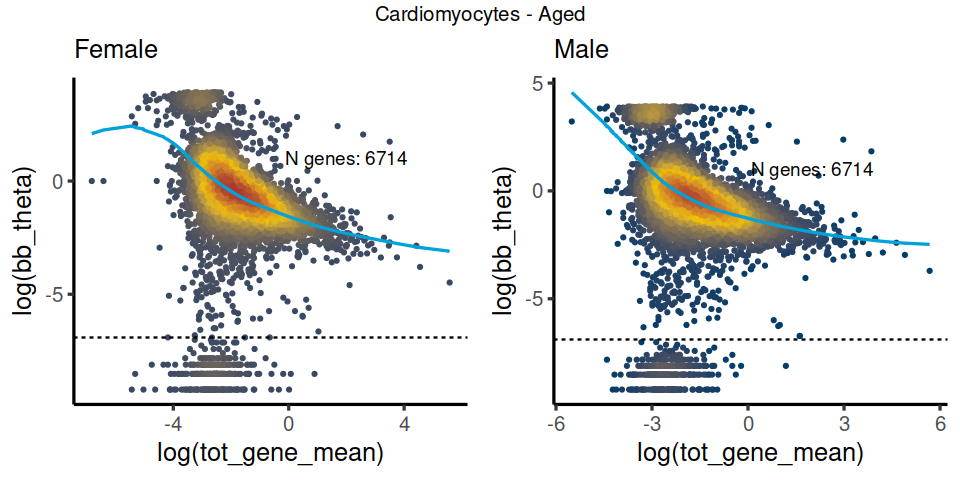

In [31]:
options(repr.plot.width = 8, repr.plot.height = 4)
sex_gr <- list("Female", "Male") 
p_disp <- mapply(function(p,q) plot_disp_fit_theta(p, midpoint = 500) +
                               labs(subtitle = q) +
                               geom_hline(yintercept = log(1e-03), linetype = "dashed"),
                 reestims_sex[[1]], sex_gr, SIMPLIFY = F)
do.call(grid.arrange, c(p_disp, ncol = 2, top = "Cardiomyocytes - Aged"))

Warning message:
“Removed 92 rows containing non-finite outside the scale range
(`stat_pointdensity()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 85 rows containing non-finite outside the scale range
(`stat_pointdensity()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


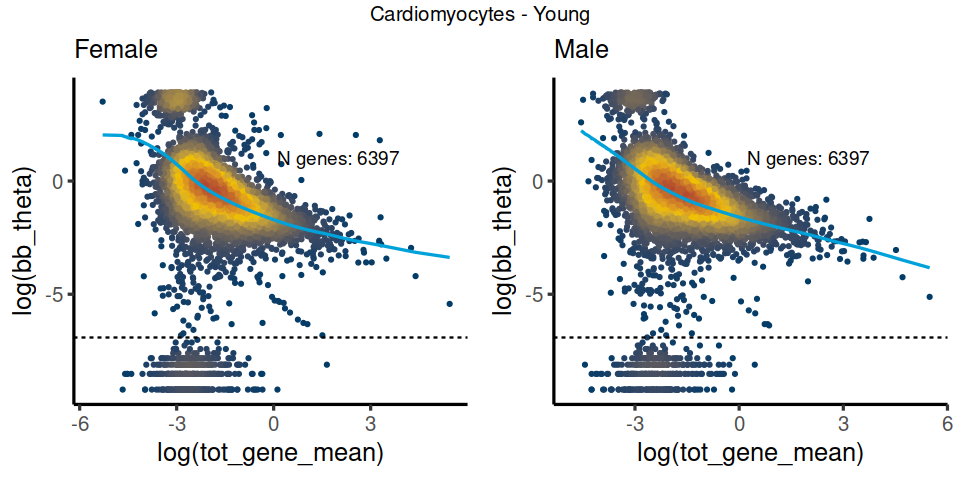

In [32]:
p_disp <- mapply(function(p,q) plot_disp_fit_theta(p, midpoint = 500) +
                               labs(subtitle = q) +
                               geom_hline(yintercept = log(1e-03), linetype = "dashed"),
                 reestims_sex[[2]], sex_gr, SIMPLIFY = F)
do.call(grid.arrange, c(p_disp, ncol = 2, top = "Cardiomyocytes - Young"))

Warning message:
“Removed 106 rows containing non-finite outside the scale range
(`stat_pointdensity()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 68 rows containing non-finite outside the scale range
(`stat_pointdensity()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_line()`).”


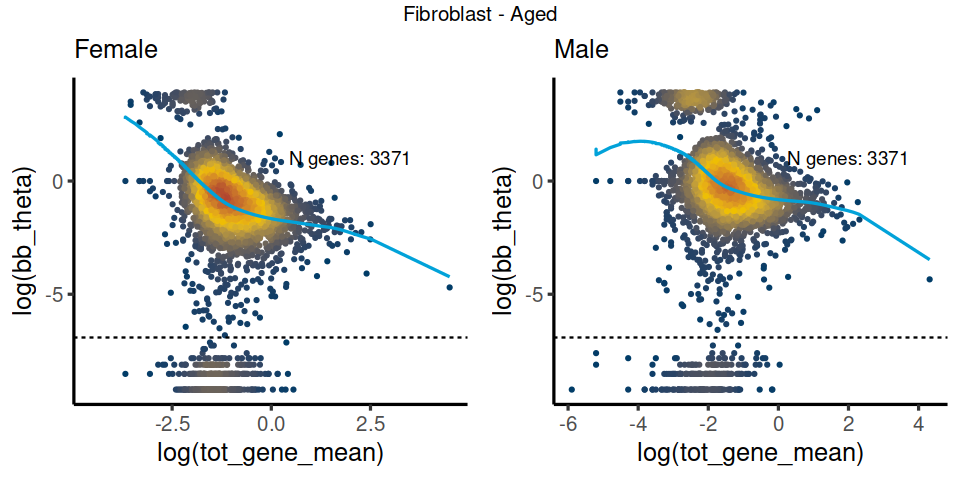

In [34]:
p_disp <- mapply(function(p,q) plot_disp_fit_theta(p, midpoint = 300) +
                               labs(subtitle = q) +
                               geom_hline(yintercept = log(1e-03), linetype = "dashed"),
                 reestims_sex[[7]], sex_gr, SIMPLIFY = F)
do.call(grid.arrange, c(p_disp, ncol = 2, top = "Fibroblast - Aged"))

Warning message:
“Removed 119 rows containing non-finite outside the scale range
(`stat_pointdensity()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 69 rows containing non-finite outside the scale range
(`stat_pointdensity()`).”


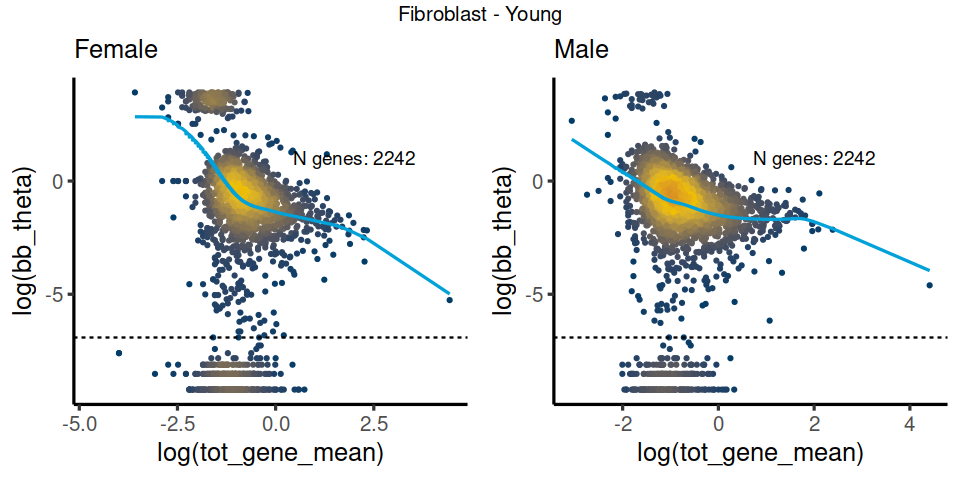

In [33]:
p_disp <- mapply(function(p,q) plot_disp_fit_theta(p, midpoint = 300) +
                               labs(subtitle = q) +
                               geom_hline(yintercept = log(1e-03), linetype = "dashed"),
                 reestims_sex[[8]], sex_gr, SIMPLIFY = F)
do.call(grid.arrange, c(p_disp, ncol = 2, top = "Fibroblast - Young"))

In [35]:
#rearranging sex level estimates by gene
reestims_sex <- lapply(reestims_sex, function(q) 
                            mapply(function(s,t) {s$group <- t;
                                           s$gene <- rownames(s);
                                           return(s)}, q, sex_gr, SIMPLIFY = F))

reestims_sex_comb <- lapply(reestims_sex, function(q) do.call(rbind, q))
reestims_sex_bygene <- lapply(reestims_sex_comb, function(q) split(q, f = q$gene))

In [41]:
#ordering beta-binomial estimates by gene names to match order in the count matrices

reestims_sex_bygene[[1]] <- reestims_sex_bygene[[1]][rownames(tot_mat_sex[[1]][[1]])]
reestims_sex_bygene[[2]] <- reestims_sex_bygene[[2]][rownames(tot_mat_sex[[2]][[1]])]
reestims_sex_bygene[[3]] <- reestims_sex_bygene[[3]][rownames(tot_mat_sex[[3]][[1]])]
reestims_sex_bygene[[4]] <- reestims_sex_bygene[[4]][rownames(tot_mat_sex[[4]][[1]])]
reestims_sex_bygene[[5]] <- reestims_sex_bygene[[5]][rownames(tot_mat_sex[[5]][[1]])]
reestims_sex_bygene[[6]] <- reestims_sex_bygene[[6]][rownames(tot_mat_sex[[6]][[1]])]
reestims_sex_bygene[[7]] <- reestims_sex_bygene[[7]][rownames(tot_mat_sex[[7]][[1]])]
reestims_sex_bygene[[8]] <- reestims_sex_bygene[[8]][rownames(tot_mat_sex[[8]][[1]])]
reestims_sex_bygene[[9]] <- reestims_sex_bygene[[9]][rownames(tot_mat_sex[[9]][[1]])]
reestims_sex_bygene[[10]] <- reestims_sex_bygene[[10]][rownames(tot_mat_sex[[10]][[1]])]
reestims_sex_bygene[[11]] <- reestims_sex_bygene[[11]][rownames(tot_mat_sex[[11]][[1]])]
reestims_sex_bygene[[12]] <- reestims_sex_bygene[[12]][rownames(tot_mat_sex[[12]][[1]])]

### Estimating global beta-binomial parameters

In [43]:
#extracting age level total and allelic counts (not split by sex)
#eaxtracting raw counts whoch will be used to estimate the model parameters
tot_mat_ct <- lapply(allelic_counts_ct, function(q)
                        as.matrix(assays(q)[['tot']]))

a1_mat_ct <- lapply(allelic_counts_ct, function(q)
                       as.matrix(assays(q)[['a1']]))


In [44]:
load_file <- system.file("extdata", "mm10_genesXY.txt", package = "ASPEN")
genesXY <- read.table(load_file)
load_file <- system.file("extdata", "mm10_imprinted_genes.xlsx", package = "ASPEN")
genesIMPR <- read.xlsx(load_file, colNames = T)
genes2remove <- c(genesXY$V1, genesIMPR$imprinted.genes)

global_estims <- mapply(function(p, q)  glob_disp(p, q, genes.excl = genes2remove, min_counts = 5),
                        a1_mat_ct, tot_mat_ct, SIMPLIFY = F)
global_estims

[[1]]
    mu.1  theta.1  alpha.1   beta.1 
0.517800 0.174300 2.970934 2.766844 

[[2]]
    mu.1  theta.1  alpha.1   beta.1 
0.519600 0.138000 3.764630 3.481152 

[[3]]
    mu.1  theta.1  alpha.1   beta.1 
0.516100 0.154600 3.338454 3.129729 

[[4]]
    mu.1  theta.1  alpha.1   beta.1 
0.504600 0.151800 3.324607 3.263785 

[[5]]
    mu.1  theta.1  alpha.1   beta.1 
0.502600 0.208700 2.407898 2.382880 

[[6]]
    mu.1  theta.1  alpha.1   beta.1 
0.508800 0.199500 2.549898 2.462157 

[[7]]
    mu.1  theta.1  alpha.1   beta.1 
0.510500 0.308600 1.654221 1.586131 

[[8]]
    mu.1  theta.1  alpha.1   beta.1 
0.506500 0.238400 2.124849 2.070604 

[[9]]
    mu.1  theta.1  alpha.1   beta.1 
0.526200 0.290400 1.811722 1.631380 

[[10]]
    mu.1  theta.1  alpha.1   beta.1 
0.523000 0.290200 1.802286 1.643859 

[[11]]
    mu.1  theta.1  alpha.1   beta.1 
0.515500 0.223900 2.302412 2.164387 

[[12]]
    mu.1  theta.1  alpha.1   beta.1 
0.507600 0.155600 3.263061 3.165550

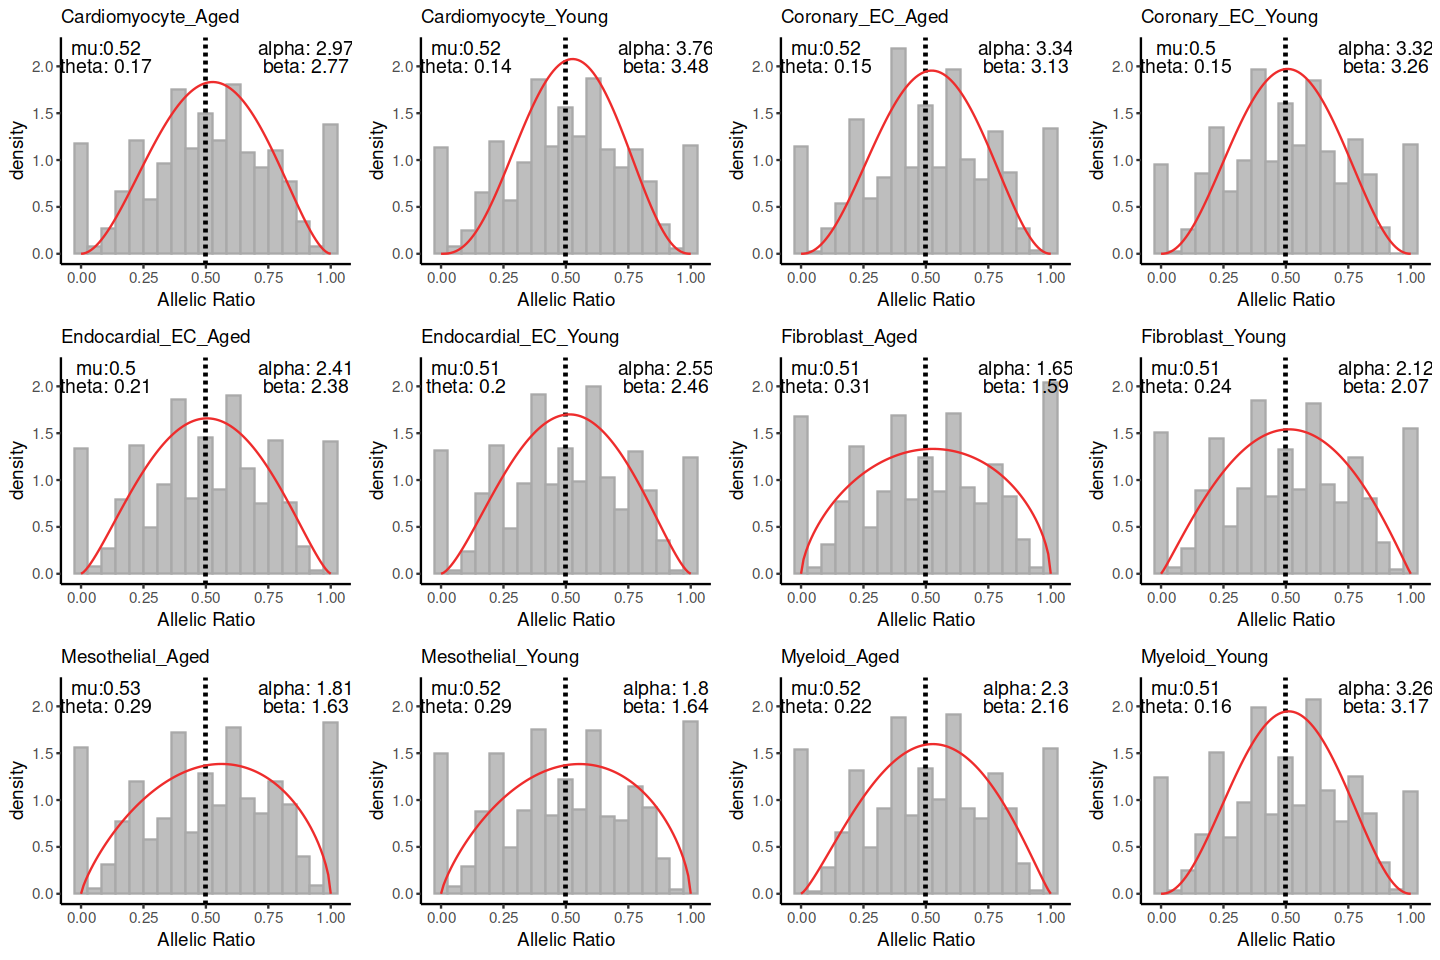

In [54]:
options(repr.plot.width = 12, repr.plot.height = 8)
groups <- as.list(names(metadata_sub_gr))
p_glob <- mapply(function(p,q,r,s) plot_glob_params(p, q, r, min_counts = 5) +
                               labs(subtitle = s),
                 a1_mat_ct, tot_mat_ct, global_estims, groups, SIMPLIFY = F)
do.call(grid.arrange, c(p_glob, ncol = 4))

### Allelic imbalance test

In [56]:
#extracting normalised counts which will be used for testing
tot_mat_norm <- lapply(allelic_counts_ct, function(q)
                        as.matrix(assays(q)[['tot_normcounts']]))

a1_mat_norm <- lapply(allelic_counts_ct, function(q)
                       as.matrix(assays(q)[['a1_normcounts']]))                       

In [62]:
#Estimating beta-binomial parameters within each cell type
param_estims_ct <- mapply(function(p, q)
                            estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat_ct, tot_mat_ct, SIMPLIFY = F)

In [63]:
reestims_ct <- lapply(param_estims_ct, function(q)
                        correct_theta(q, delta_set = 50, N_set = 30, thetaFilter = 1e-03))

In [74]:
#recoding sex labels to avoid conflict
metadata_sub_gr <- lapply(metadata_sub_gr, function(q) {q$pred.sex <- recode(q$pred.sex, "F" = "Female", "M" = "Male");
                                                        return(q)})

In [96]:
source("/g/data/zk16/veronika/projects/forpubl/ASPEN/R/allelic_imbalance_sc.R")
bb_test_res <- mapply(function(p, q, r, s, t, u) bb_mean(p, q, 
                                                      estimates = r, 
                                                      estimates_group = s,  
                                                      glob_params = t, 
                                                      metadata = u, 
                                                      min_cells = 5, 
                                                      batch = "pred.sex"), 
                        a1_mat_norm, tot_mat_norm, reestims_ct, reestims_sex_bygene, global_estims, metadata_sub_gr, SIMPLIFY = F)

In [97]:
# removing genes with insufficient number of cells
bb_test_res <- lapply(bb_test_res, function(q) q[!is.na(q$pval_mean),])

### Adding gene annotation

In [98]:
#adding gene annotation
gene_anno <- rtracklayer::readGFF("/g/data/zk16/veronika/projects/vierbuct/genomes/reference/Mus_musculus.GRCm38.102.subset.gtf")
mm10_chr <- c(seq(1:19), "X", "Y")
gene_anno <- gene_anno[gene_anno$seqid %in% mm10_chr,]
gene_anno <- gene_anno[gene_anno$type == "gene",]
gene_anno$seqid <- sub("^", "chr", gene_anno$seqid)
gene_anno$coord <- paste0(gene_anno$seqid, ":", gene_anno$start, "-", gene_anno$end)
gene_anno$Length <- gene_anno$end - gene_anno$start + 1

In [99]:
bb_test_res <- lapply(bb_test_res, function(q) {q$fdr_mean <- p.adjust(q$pval, method = "fdr");
                                                q$gene_coord <- gene_anno$coord[match(rownames(q), gene_anno$gene_name)];
                                                q$gene_strand <- gene_anno$strand[match(rownames(q), gene_anno$gene_name)];
                                                q$gene_length <- gene_anno$Length[match(rownames(q), gene_anno$gene_name)];
                                                return(q)})

In [100]:
lapply(bb_test_res, dim)

[[1]]
[1] 1627   32

[[2]]
[1] 1418   32

[[3]]
[1] 138  32

[[4]]
[1] 105  32

[[5]]
[1] 399  32

[[6]]
[1] 300  32

[[7]]
[1] 732  32

[[8]]
[1] 471  32

[[9]]
[1] 192  32

[[10]]
[1] 236  32

[[11]]
[1] 317  32

[[12]]
[1] 244  32

In [101]:
bb_test_res <- lapply(bb_test_res, function(q) q[,c(30:32, 1:29)]) 
bb_test_res <- lapply(bb_test_res, function(q) q[order(q$fdr_mean),])                    

In [103]:
res <- "/g/data/zk16/veronika/projects/multiome/test_res/aspen/"
filename <- paste0(res, "20250923_aged_young_by_celltype_allelicimb.xlsx")
excel <- createWorkbook(filename)
  for (i in 1:length(bb_test_res)){
  addWorksheet(excel, groups[[i]])
  writeData(excel, sheet = i, bb_test_res[[i]], rowNames=T, colNames=T)
  saveWorkbook(excel, file = filename, overwrite = TRUE)
}

### Genes with allelic imbalance that hcnage with age

In [114]:
gene_change_CM <- rownames(bb_test_res[[2]])[which(rownames(bb_test_res[[2]][bb_test_res[[2]]$fdr_mean < 0.05,]) %in% 
                                            rownames(bb_test_res[[1]][!(bb_test_res[[1]]$fdr_mean < 0.1),]))]
gene_change_CM

[1] "Sbf2"          "Dyrk1a"        "Zfp385b"       "Sesn1"        
  [5] "Mpdz"          "Plekha6"       "Lnpep"         "Nbeal1"       
  [9] "Tpr"           "Nppb"          "Phf14"         "Unc45b"       
 [13] "Kcnd3"         "Frmd6"         "Kcng2"         "Snx13"        
 [17] "Casz1"         "Lclat1"        "Bbx"           "Bcas3"        
 [21] "Csnk1a1"       "Fbxo32"        "Agl"           "Cstf3"        
 [25] "Gpam"          "Pde7a"         "Mdm4"          "Dtnbp1"       
 [29] "Nrap"          "Tbl1xr1"       "Mbd5"          "Tra2a"        
 [33] "Pdss2"         "Ttc14"         "Usp2"          "Mef2a"        
 [37] "Gpbp1l1"       "Tom1l2"        "Ppfibp2"       "Jmjd1c"       
 [41] "Atxn7"         "Esrrg"         "Tnni3"         "Lin52"        
 [45] "Fxr1"          "Nedd4"         "Rbm5"          "Egln3"        
 [49] "Mgrn1"         "Acsl1"         "Braf"          "Zfp280d"      
 [53] "Senp6"         "Cep85"         "Pgm1"          "Hspa9"        
 [57] "Asb15"         "Cop1"          "Nrip1"         "Elf2"         
 [61] "Wdr33"         "Ivns1abp"      "Pik3r1"        "Homer2"       
 [65] "Cltc"          "Tasor"         "Rock1"         "Faf1"         
 [69] "Ikzf2"         "Ndufs1"        "Itch"          "Lpp"          
 [73] "Larp4b"        "Hadha"         "Exoc6"         "Arfgef1"      
 [77] "Txndc11"       "Foxp1"         "Ap1g1"         "Nsd1"         
 [81] "Gpatch8"       "Ankhd1"        "Tpk1"          "1810026B05Rik"
 [85] "Gm5532"        "Actn2"         "Ccnt2"         "Atg10"        
 [89] "Spop"          "Gm13601"       "Med13"         "Gm36827"      
 [93] "Luc7l2"        "Pi4ka"         "Ambra1"        "Zfp608"       
 [97] "Dusp16"        "Zfp148"        "Ube3c"         "Atp5pb"       
[101] "Yap1"          "Dennd4c"       "Ptgr2"         "Nt5c2"        
[105] "Kmt2e"         "Kif21a"        "Rab3ip"        "Cpeb2"        
[109] "Myo18a"        "Tmem131"       "Nlk"

In [115]:
CM_aged_changing <- reestims_sex_bygene[[1]][names(reestims_sex_bygene[[1]]) %in% gene_change_CM]
CM_young_changing <- reestims_sex_bygene[[2]][names(reestims_sex_bygene[[2]]) %in% gene_change_CM]

In [119]:
CM_aged_changing <- lapply(CM_aged_changing, function(q) q[,c("AR", "group", "gene")])
CM_young_changing <- lapply(CM_young_changing, function(q) q[,c("AR", "group", "gene")])                          

In [121]:
CM_aged_changing <- do.call(rbind, CM_aged_changing)
CM_aged_changing$age <- "Aged"
CM_young_changing <- do.call(rbind, CM_young_changing)
CM_young_changing$age <- "Young"

In [148]:
CM_changing <- rbind(CM_aged_changing, CM_young_changing)
CM_changing$fdr <- bb_test_res[[2]]$fdr_mean[match(CM_changing$gene, rownames(bb_test_res[[2]]))]
CM_changing <- CM_changing[order(CM_changing$fdr, decreasing = T),]
head(CM_changing)

,AR,group,gene,age,fdr
,<dbl>,<chr>,<chr>,<chr>,<dbl>
Nlk.Nlk,0.5009821,Female,Nlk,Aged,0.04945903
Nlk.Nlk1,0.5346157,Male,Nlk,Aged,0.04945903
Nlk.Nlk2,0.5376758,Female,Nlk,Young,0.04945903
Nlk.Nlk11,0.4865010,Male,Nlk,Young,0.04945903
Tmem131.Tmem131,0.4947619,Female,Tmem131,Aged,0.04929493
Tmem131.Tmem1311,0.5135173,Male,Tmem131,Aged,0.04929493


In [ ]:
#Tile plot for changes in allelic ratio
plot_tiles_ar <- function(df){
    ggplot(df, aes(x = group, y = gene, fill = round(AR, 4))) +
        geom_tile() +
        theme_classic(base_size = 20) +
        scale_fill_gradient2(low = cont_pal[1], mid = cont_pal[6], high = cont_pal[11], 
                             midpoint = 0.5, name = "Allelic Ratio", limits=c(0,1)) +
        theme(legend.position = "bottom", legend.box.spacing = unit(0, "pt"),
              axis.title.y = element_blank(), axis.title.x = element_blank(), 
              axis.text.x = element_text(angle = 90, hjust = 0.5, vjust = 0.5),
              plot.subtitle = element_text(hjust = 1)) +
    facet_wrap(~age)
}

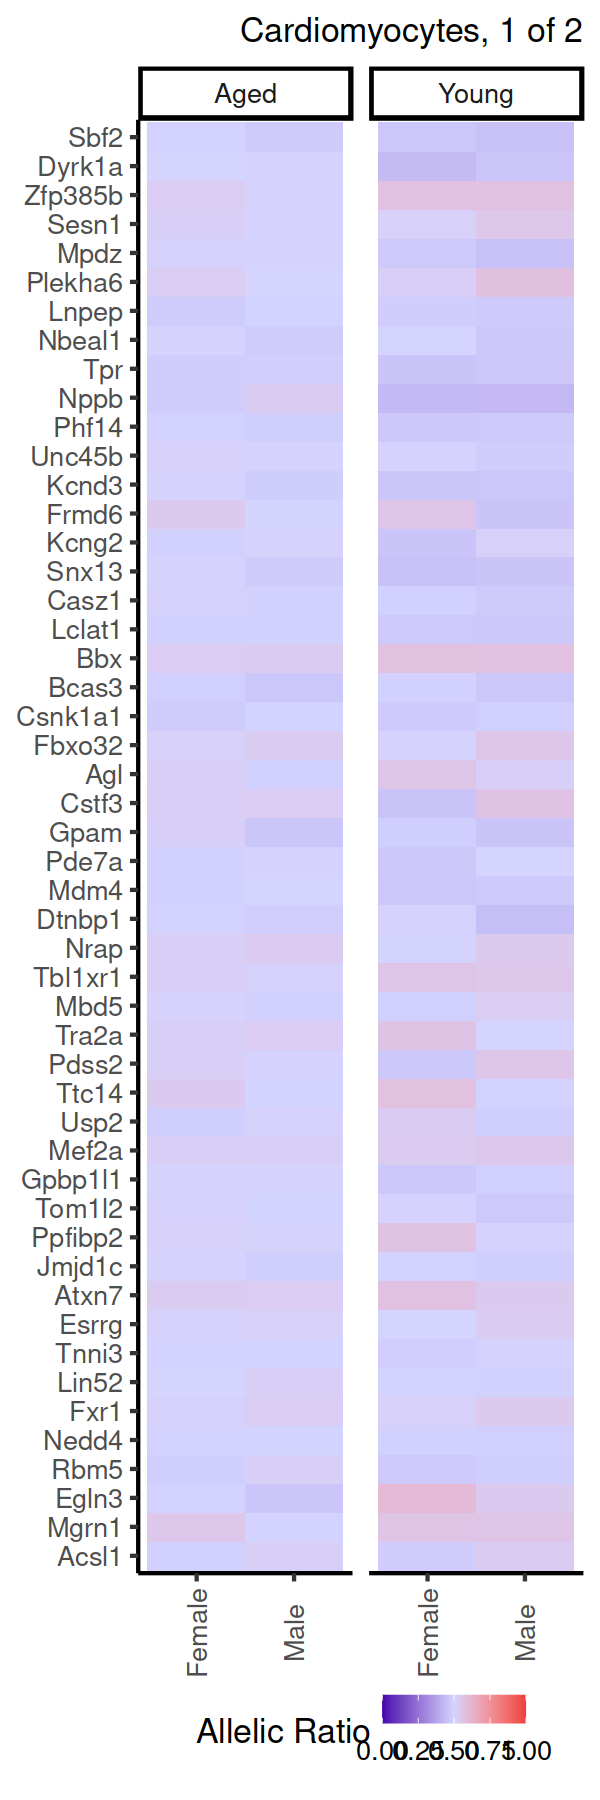

In [160]:
options(repr.plot.width = 5, repr.plot.height = 15)
cont_pal <- pal_gsea()(11)
CM_changing$gene <- factor(CM_changing$gene, levels = unique(CM_changing$gene))
plot_tiles_ar(CM_changing[CM_changing$gene %in% gene_change_CM[c(1:50)],]) +
    labs(subtitle = "Cardiomyocytes, 1 of 2")

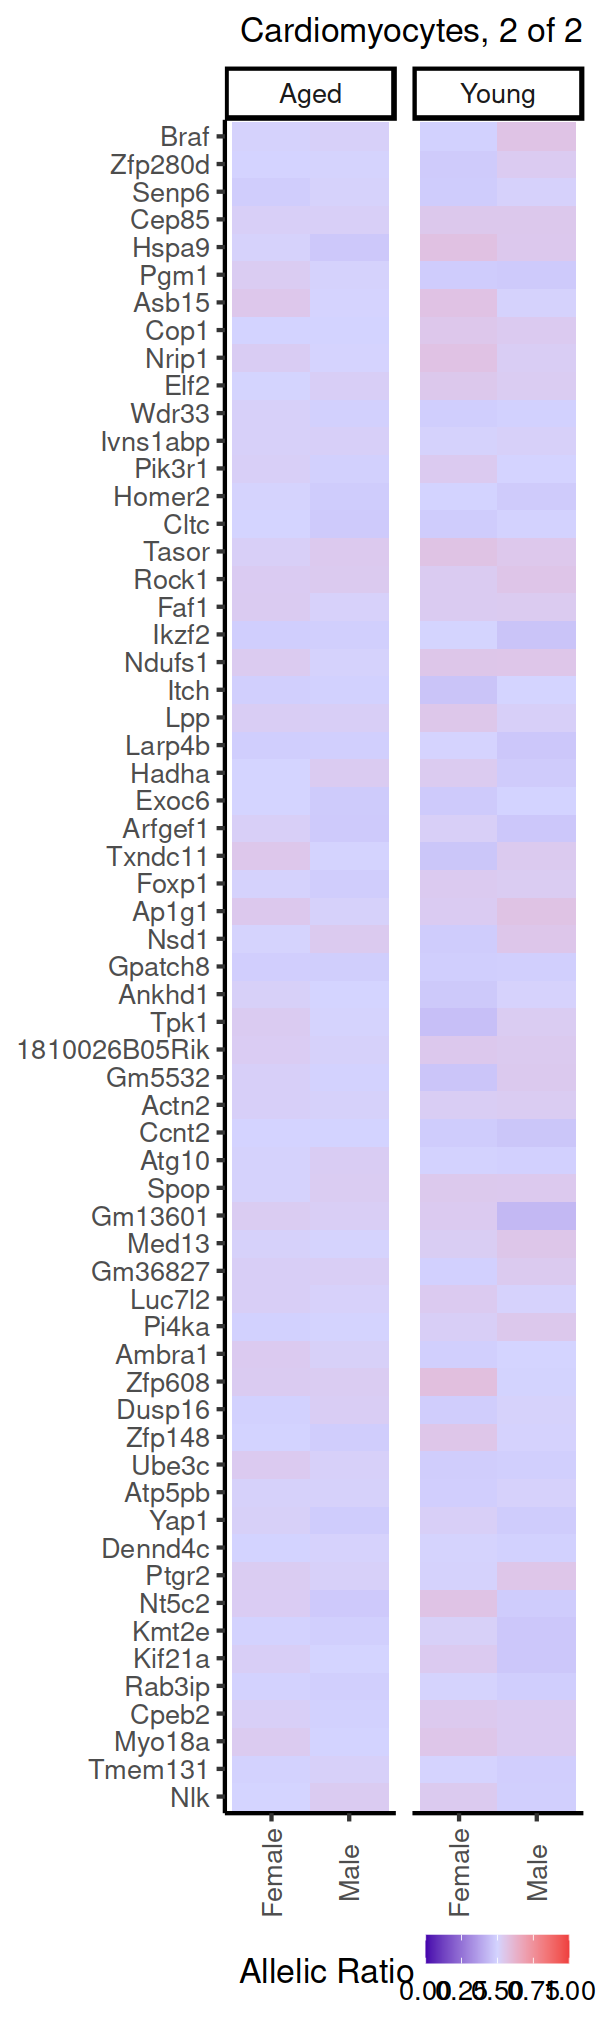

In [163]:
options(repr.plot.width = 5, repr.plot.height = 17)
plot_tiles_ar(CM_changing[CM_changing$gene %in% gene_change_CM[c(51:111)],]) +
    labs(subtitle = "Cardiomyocytes, 2 of 2")

In [164]:
gene_change_fibro <- rownames(bb_test_res[[8]])[which(rownames(bb_test_res[[8]][bb_test_res[[8]]$fdr_mean < 0.05,]) %in% 
                                            rownames(bb_test_res[[7]][!(bb_test_res[[7]]$fdr_mean < 0.1),]))]
gene_change_fibro

[1] "Slit3"      "Ghr"        "Dlc1"       "Csgalnact1" "Vcl"       
 [6] "Nipbl"      "Csnk1a1"    "Creb5"      "Serpine1"   "Zfp521"    
[11] "Nr3c1"      "Slc8a1"     "Tgfbr3"     "Fbxl7"      "Samd4"     
[16] "Rock2"      "Cd36"       "Exoc4"      "C7"         "Mycbp2"    
[21] "Stag1"

In [174]:
fibro_aged_changing <- reestims_sex_bygene[[7]][names(reestims_sex_bygene[[7]]) %in% gene_change_fibro]
fibro_young_changing <- reestims_sex_bygene[[8]][names(reestims_sex_bygene[[8]]) %in% gene_change_fibro]

In [175]:
fibro_aged_changing <- lapply(fibdro_aged_changing, function(q) q[,c("AR", "group", "gene")])
fibro_young_changing <- lapply(fibro_young_changing, function(q) q[,c("AR", "group", "gene")])    

In [176]:
fibro_aged_changing <- do.call(rbind, fibro_aged_changing)
fibro_aged_changing$age <- "Aged"
fibro_young_changing <- do.call(rbind, fibro_young_changing)
fibro_young_changing$age <- "Young"

In [178]:
fibro_changing <- rbind(fibro_aged_changing, fibro_young_changing)
fibro_changing$fdr <- bb_test_res[[8]]$fdr_mean[match(fibro_changing$gene, rownames(bb_test_res[[8]]))]
fibro_changing <- fibro_changing[order(fibro_changing$fdr, decreasing = T),]
head(fibro_changing)

,AR,group,gene,age,fdr
,<dbl>,<chr>,<chr>,<chr>,<dbl>
Stag1.Stag1,0.4977558,Female,Stag1,Aged,0.04671114
Stag1.Stag11,0.5121202,Male,Stag1,Aged,0.04671114
Stag1.Stag12,0.4807778,Female,Stag1,Young,0.04671114
Stag1.Stag111,0.5781955,Male,Stag1,Young,0.04671114
Mycbp2.Mycbp2,0.5347011,Female,Mycbp2,Aged,0.04363073
Mycbp2.Mycbp21,0.4703518,Male,Mycbp2,Aged,0.04363073


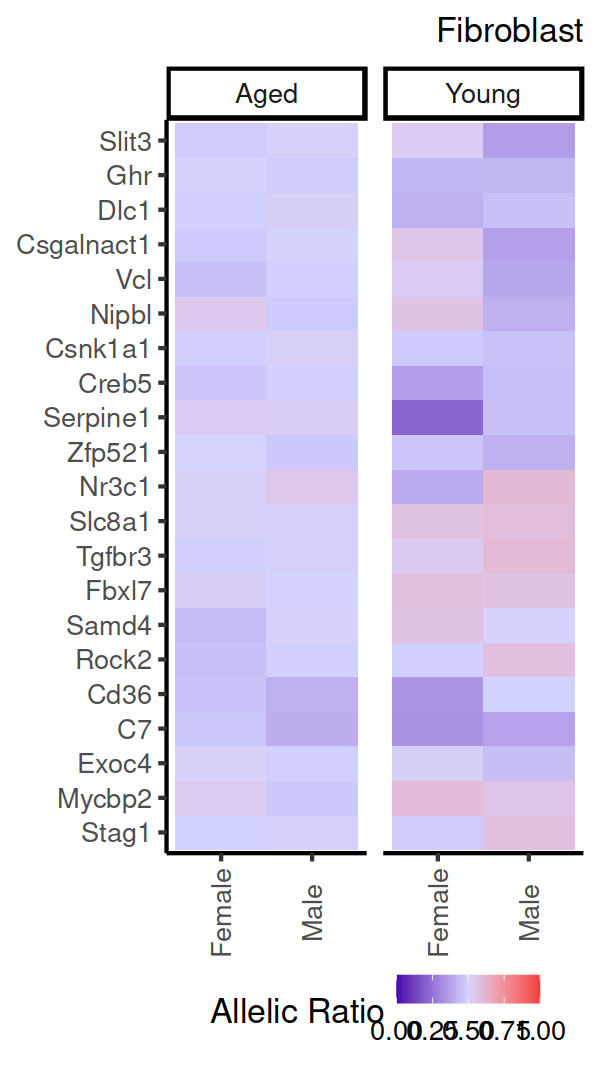

In [182]:
options(repr.plot.width = 5, repr.plot.height = 9)
cont_pal <- pal_gsea()(11)
fibro_changing$gene <- factor(fibro_changing$gene, levels = unique(fibro_changing$gene))
plot_tiles_ar(fibro_changing[fibro_changing$gene %in% gene_change_fibro,]) +
    labs(subtitle = "Fibroblast")

In [183]:
reestims_sex_bygene[[8]]["Nipbl"]

,N,AR,tot_gene_mean,tot_gene_variance,alpha,beta,bb_mu,bb_theta,id,theta_smoothed,thetaCorrected,theta_common,resid,group,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Nipbl,3,0.5652174,1.231481,1.749654,507.808714,380.88923,0.5714,0.0011,1824,0.2323965,0.1525760,0.2323965,-0.2312965,Female,Nipbl
Nipbl1,7,0.4071649,1.304094,2.177571,5.339827,7.14278,0.4278,0.0801,1824,0.2025390,0.1630273,0.2025390,-0.1224390,Male,Nipbl


In [184]:
reestims_sex_bygene[[7]]["Nipbl"]

,N,AR,tot_gene_mean,tot_gene_variance,alpha,beta,bb_mu,bb_theta,id,theta_smoothed,thetaCorrected,theta_common,resid,group,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Nipbl,6,0.5432782,1.1227437,1.847198,2.141949,1.835330,0.5385,0.2514,2749,0.1825536,0.2149927,0.1825536,0.06884641,Female,Nipbl
Nipbl1,2,0.4755435,0.8539945,1.158182,2.904782,3.121975,0.4820,0.1659,2749,0.4523068,0.3591415,0.4523068,-0.28640680,Male,Nipbl
